# Feature variation by substitution ($\nu_{\phi}$)

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Imports and database setup

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from progressbar import ProgressBar

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope
engine = init_db()

## 2 Variation of features upon substitution

First build our data

In [3]:
model = Model(Time.discrete, Source.majority, Past.last_bin, Durl.all)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar()(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, destination = substitution.features(feature)
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'source': source,
                         'destination': destination})

original_variations = pd.DataFrame(data)
del data

Got 9071 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all)


100% (9071 of 9071) |#######################################################################################################################################| Elapsed Time: 0:01:03 Time: 0:01:03


In [4]:
variations = original_variations\
    .groupby(['destination_id', 'occurrence', 'feature'], as_index=False).mean()\
    .groupby(['cluster_id', 'feature'], as_index=False)['destination', 'source', 'feature'].mean()
variations

,cluster_id,feature,destination,source
0,662,aoa,NaN,NaN
1,662,betweenness,-7.695924,-9.572382
2,662,clustering,-5.279287,-4.836344
3,662,degree,-7.883823,-7.324207
4,662,frequency,6.960348,8.617762
5,662,letters_count,9.000000,9.000000
6,662,orthographical_density,0.000000,0.000000
7,662,pagerank,-9.689357,-9.356464
8,662,phonemes_count,6.000000,7.000000
9,662,phonological_density,0.000000,0.000000


For each feature $\phi$, plot:

* $\nu_{\phi}$, the variation of the feature upon substitution
* $\nu_{\phi}^0$ (which is the average feature value), i.e. what happens under $\mathcal{H}_0$
* $\nu_{\phi}^{00}$ (which is the average feature value for neighbours of the words with $\phi(w) = x$), i.e. what happens under $\mathcal{H}_{00}$
* $y = x$, i.e. what happens if there is no substitution

In [5]:
def plot_variation(x, y, **kwargs):
    data = kwargs.pop('data')
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    x_name = y_name = ''
    if isinstance(x, str):
        x_name = x
        x = data[x_name]
    if isinstance(y, str):
        y_name = y
        y = data[y_name]
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    h0s = Substitution.feature_average(feature) * np.ones(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        values[i] = y[x_bins == i].mean()
        cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
        h0ns[i] = Substitution.feature_average(feature, synonyms_from_range=(bins[i], bins[i+1]))
    
    # Plot.
    plt.plot(middles, values, '-', lw=2, color=color, label=r'$\nu_{\phi}$')
    plt.fill_between(middles, values - cis, values + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, h0s, '--', color=sb.desaturate(color, 0.2),
             label=r'$\nu_{\phi}^0$')
    plt.plot(middles, h0ns, linestyle='-.', color=sb.desaturate(color, 0.2),
             label=r'$\nu_{\phi}^{00}$')
    plt.plot(middles, middles, linestyle='dotted', color=sb.desaturate(color, 0.2),
             label=r'$y = x$')
    lmin, lmax = middles[0], middles[-1]
    h0min, h0max = min(h0s.min(), h0ns.min()), max(h0s.max(), h0ns.max())
    # Rescale limits if we're touching H0 or H00.
    if h0min < lmin:
        lmin = h0min - (lmax - h0min) / 10
    elif h0max > lmax:
        lmax = h0max + (h0max - lmin) / 10
    plt.xlim(lmin, lmax)
    plt.ylim(lmin, lmax)

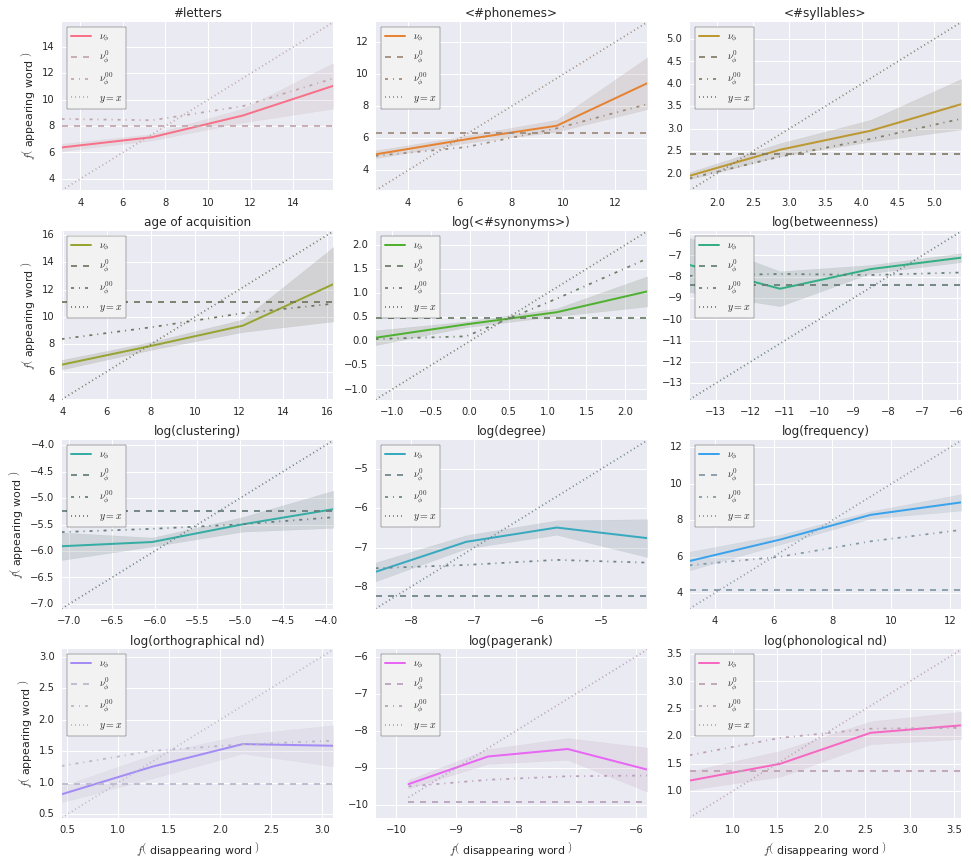

In [6]:
feature_order = sorted(Substitution.__features__,
                       key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=variations, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=feature_order, hue_order=feature_order)
g.map_dataframe(plot_variation, 'source', 'destination')
g.set_titles('{col_name}')
g.set_xlabels(r'$f \left( \right.$ disappearing word $\left. \right)$')
g.set_ylabels(r'$f \left( \right.$ appearing word $\left. \right)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)

Then plot $\nu_{\phi} - \nu_{\phi}^{00}$ for each feature (i.e. the measured bias) to see how they compare

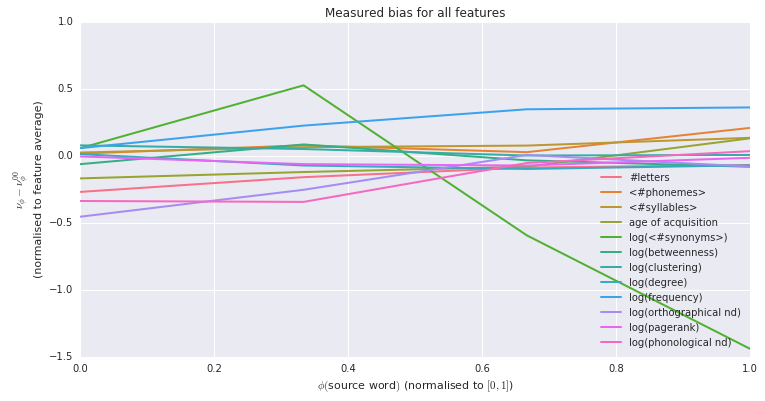

In [7]:
palette = sb.color_palette('husl', len(Substitution.__features__))
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(sorted(Substitution.__features__,
                                   key=lambda f: Substitution._transformed_feature(f).__doc__)):
    x = variations[variations['feature'] == feature]['source']
    y = variations[variations['feature'] == feature]['destination']
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    
    # Compute bin values.
    h0 = Substitution.feature_average(feature)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    #cis = np.zeros(bin_count)
    for i in range(bin_count):
        values[i] = y[x_bins == i].mean()
        #cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
        h0ns[i] = Substitution.feature_average(feature, synonyms_from_range=(bins[i], bins[i+1]))
    
    # Plot.
    ax.plot(np.linspace(0, 1, bin_count), (values - h0ns) / h0, '-', lw=2, color=palette[j],
            label=Substitution._transformed_feature(feature).__doc__)

ax.legend(loc='lower right')
ax.set_title('Measured bias for all features')
ax.set_xlabel(r'$\phi($source word$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi} - \nu_{\phi}^{00}$' + '\n(normalised to feature average)')

TODO:
* grouper par shift/pas-shift